In [1]:
from SparseBandit import fliphat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

The base class is `DP_SLCB` within `fliphat` module. It can be initiated with $K$ (number of arms), $d$ (context dimension), $\epsilon, \delta$ (privacy parameters) and other algorithm hyperparameters as mentioned in text. Note $s$ does not need to be exactly true spartsity.

In [6]:
K = 3
d = 400

model1 = fliphat.DP_SLCB(K, d, epsilon=0.33, M0=0.16, eta=1e-4, s=10, bmax=5, xmax=2)
model2 = fliphat.DP_SLCB(K, d, epsilon=1.0, M0=0.16, eta=1e-4, s=10, bmax=5, xmax=2)
model3 = fliphat.DP_SLCB(K, d, epsilon=3, M0=0.16, eta=1e-4, s=10, bmax=5, xmax=2)
models = [model1, model2, model3]

The model is simple

$$y(t) = x_{a_k}(t)^\top \beta + \epsilon(t)$$

where $d=300$ (context dimension), $K=3$ (number of arms) and the true parameter $\beta$ is sparse with only firs $s=5$ coordinates non-zero (and equals 1).

The model has the following methods:
1. `take_action` - takes contexts at a time point and returns an action (arm number)
2. `observe_reward` - to feed back the reward observed from only the chosen arm

The second method also updates the parameter (`update_beta` method), but only at specific time points (doubling) and using only data from last episode (forgetting)

The `update_beta` method draws from `NIHT` (Noisy Iterative Hard Thresholding) implemented in the `utils` module.

In [7]:
T = 15000
beta = np.zeros(d)
beta[:5] = 1.

opt_reward = np.zeros((len(models), T))
obs_reward = np.zeros((len(models), T))
    
for t in tqdm(range(T)):
    
    # get contexts for this round 
    X, y = fliphat.get_contexts_rewards(K, d, beta)
    
    for j, model in enumerate(models):
        # take action
        action = model.take_action(X)

        # observe reward corresponding to action
        model.observe_reward(y[action])

        # to compute pseudo-regret
        Y = X @ beta
        opt_reward[j,t] = np.max(Y)
        obs_reward[j,t] = Y[action]

100%|██████████| 15000/15000 [01:09<00:00, 215.71it/s] 


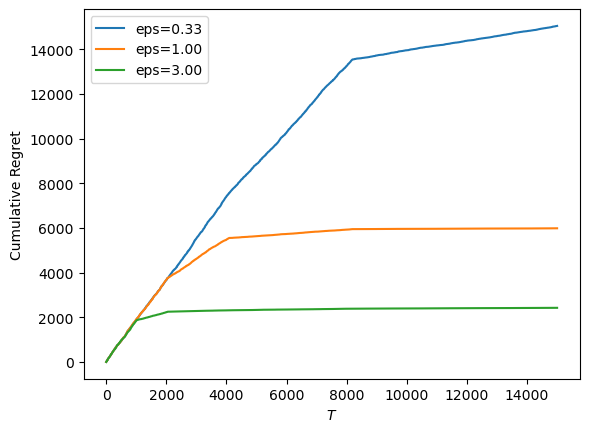

In [8]:
# this is not regret really, because regret is defined in terms of expected reward
regret =  opt_reward - obs_reward
cumregret = np.cumsum(regret, axis=1)

plt.plot(range(T), cumregret[0], label='eps=0.33')
plt.plot(range(T), cumregret[1], label='eps=1.00')
plt.plot(range(T), cumregret[2], label='eps=3.00')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('Cumulative Regret')
plt.show()

For simulation purposes, one can use `SLCB` under `fliphat_simulation_utils` module, which performs the same operations more efficiently - essentially, the entire contexts and rewards (over all time points) are passed at start and the `for` loop here is replaced via `jax.lax.fori_loop`. We compare with the sparsity agnostic bandit - whose efficient (for simulation) version is `SA_bandit` under the `sparsity_agnostic` module.